# Get the libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, r2_score, silhouette_score, davies_bouldin_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

from yellowbrick.cluster import KElbowVisualizer

from collections import Counter

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
wine=pd.read_csv('/Users/Jeff/Downloads/winequality.csv')

In [3]:
wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  good color  
0      9.4        5     0   red  
1      9.8        5     0   red  
2      9.8        5     0   red  
3      9.8        6     0   red  
4      9.4        5     0   red

In [4]:
wine.shape

(6497, 14)

# Data preprocessing

## Missing value

In [5]:
wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
good                    0
color                   0
dtype: int64

No missing value

## Columns data types

In [6]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  good                  6497 non-null   int64  
 13  color                 6497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 710.7+ KB


As we can most of the columns are numerical, there is only column color which is object type

### Color column

In [7]:
# Check the value counts of the column
wine.color.value_counts()

white    4898
red      1599
Name: color, dtype: int64

As we only have 2 values in the color column, we will use label encoder to assign a numerical value to each categorical value

In [8]:
dct={'white':0, 'red':1}
wine.color=wine.color.map(dct)

In [9]:
wine.color.value_counts()

0    4898
1    1599
Name: color, dtype: int64

In [10]:
# Check the dtype
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  good                  6497 non-null   int64  
 13  color                 6497 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 710.7 KB


Ok all columns are numerical

## Other column manipulation

### good column

In [11]:
# See the value counts of column "good"
wine.good.value_counts()

0    5220
1    1277
Name: good, dtype: int64

In [12]:
# See the value counts of column "quality" when the column "good" is equal to 1
wine.loc[wine['good']==1].quality.value_counts()

7    1079
8     193
9       5
Name: quality, dtype: int64

In [13]:
# See the value counts of column "quality" when the column "good" is equal to 0
wine.loc[wine['good']==0].quality.value_counts()

6    2836
5    2138
4     216
3      30
Name: quality, dtype: int64

In [14]:
# See the value counts of column "quality"
wine.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

As we can see, the column good is determined by the column quality. We don't need to keep both column, we choose to drop the column good as it has less information and our goal is to predict the quality

In [15]:
# Drop the column "good"
wine.drop('good', axis=1, inplace=True)

### Color column

We don't think that the color has an impact on the quality of the wine. So we decide to drop this column.

In [16]:
# Drop color column
wine.drop('color', axis=1, inplace=True)

### Quality column (output)

As we can see our output is categorical ordinal values. In order to build a regression model we will assign to a category each value:
* if quality < 6 then bad (0)
* if quality < 8 then medium (1)
* if quality > 8 then good (2)

In [17]:
wine.quality=np.where(wine.quality < 6, 0, wine.quality)
wine.quality=np.where(wine.quality == 6, 1, wine.quality)
wine.quality=np.where(wine.quality == 7, 1, wine.quality)
wine.quality=np.where(wine.quality > 7, 2, wine.quality)

In [18]:
wine.quality.value_counts()

1    3915
0    2384
2     198
Name: quality, dtype: int64

## Export for vizualisation

In [19]:
wine.to_csv('wine.csv', sep='/', index=False)

In [20]:
wine.corr()

fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000          0.219008     0.324436   
volatile acidity           0.219008          1.000000    -0.377981   
citric acid                0.324436         -0.377981     1.000000   
residual sugar            -0.111981         -0.196011     0.142451   
chlorides                  0.298195          0.377124     0.038998   
free sulfur dioxide       -0.282735         -0.352557     0.133126   
total sulfur dioxide      -0.329054         -0.414476     0.195242   
density                    0.458910          0.271296     0.096154   
pH                        -0.252700          0.261454    -0.329808   
sulphates                  0.299568          0.225984     0.056197   
alcohol                   -0.095452         -0.037640    -0.010493   
quality                   -0.077002         -0.258263     0.074475   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity              -0.111981   0.298195            -0.282735   
volatile acidity           -0.196011   0.377124            -0.352557   
citric acid                 0.142451   0.038998             0.133126   
residual sugar              1.000000  -0.128940             0.402871   
chlorides                  -0.128940   1.000000            -0.195045   
free sulfur dioxide         0.402871  -0.195045             1.000000   
total sulfur dioxide        0.495482  -0.279630             0.720934   
density                     0.552517   0.362615             0.025717   
pH                         -0.267320   0.044708            -0.145854   
sulphates                  -0.185927   0.395593            -0.188457   
alcohol                    -0.359415  -0.256916            -0.179838   
quality                    -0.030476  -0.189354             0.053339   

                      total sulfur dioxide   density        pH  sulphates  \
fixed acidity                    -0.329054  0.458910 -0.252700   0.299568   
volatile acidity                 -0.414476  0.271296  0.261454   0.225984   
citric acid                       0.195242  0.096154 -0.329808   0.056197   
residual sugar                    0.495482  0.552517 -0.267320  -0.185927   
chlorides                        -0.279630  0.362615  0.044708   0.395593   
free sulfur dioxide               0.720934  0.025717 -0.145854  -0.188457   
total sulfur dioxide              1.000000  0.032395 -0.238413  -0.275727   
density                           0.032395  1.000000  0.011686   0.259478   
pH                               -0.238413  0.011686  1.000000   0.192123   
sulphates                        -0.275727  0.259478  0.192123   1.000000   
alcohol                          -0.265740 -0.686745  0.121248  -0.003029   
quality                          -0.041265 -0.285212  0.019471   0.024706   

                       alcohol   quality  
fixed acidity        -0.095452 -0.077002  
volatile acidity     -0.037640 -0.258263  
citric acid          -0.010493  0.074475  
residual sugar       -0.359415 -0.030476  
chlorides            -0.256916 -0.189354  
free sulfur dioxide  -0.179838  0.053339  
total sulfur dioxide -0.265740 -0.041265  
density              -0.686745 -0.285212  
pH                    0.121248  0.019471  
sulphates            -0.003029  0.024706  
alcohol               1.000000  0.414315  
quality               0.414315  1.000000

## Scale

In [21]:
wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        0  
1      9.8        0  
2      9.8        0  
3      9.8        1  
4      9.4        0

As we can see, the columns have not the same scale, we will rescale our database. \
We will use StandardScaler()

In [22]:
scaler=StandardScaler()
X_scale=scaler.fit_transform(wine.drop('quality', axis=1))

In [23]:
X=pd.DataFrame(X_scale)

In [24]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [25]:
X.columns=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

In [26]:
X.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.142473          2.188833    -2.192833       -0.744778   0.569958   
1       0.451036          3.282235    -2.192833       -0.597640   1.197975   
2       0.451036          2.553300    -1.917553       -0.660699   1.026697   
3       3.073817         -0.362438     1.661085       -0.744778   0.541412   
4       0.142473          2.188833    -2.192833       -0.744778   0.569958   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -1.100140             -1.446359  1.034993  1.813090   0.193097   
1            -0.311320             -0.862469  0.701486 -0.115073   0.999579   
2            -0.874763             -1.092486  0.768188  0.258120   0.797958   
3            -0.762074             -0.986324  1.101694 -0.363868   0.327510   
4            -1.100140             -1.446359  1.034993  1.813090   0.193097   

    alcohol  
0 -0.915464  
1 -0.580068  
2 -0.580068  
3 -0.580068  
4 -0.915464

# Imbalance

In [27]:
# Define y
y=wine['quality']

In [28]:
counter=Counter(y)
print(counter)

Counter({1: 3915, 0: 2384, 2: 198})


As we can see, our y is highly imbalanced. We will use oversampling and undersampling in order to rebalanced out output

In [29]:
over_strategy={2:1000}
under_strategy={1: 3000}

over=RandomOverSampler(sampling_strategy=over_strategy)
under=RandomUnderSampler(sampling_strategy=under_strategy)

steps=[('o',over), ('u',under)]
pipe=Pipeline(steps=steps)

X_im,y_im=pipe.fit_resample(X,y)

counter=Counter(y_im)
print(counter)

Counter({1: 3000, 0: 2384, 2: 1000})


# Features selection

As we have only numerical columns, we will use SelectKbest with f_classif

In [30]:
X_im.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.142473          2.188833    -2.192833       -0.744778   0.569958   
1       0.451036          3.282235    -2.192833       -0.597640   1.197975   
2       0.451036          2.553300    -1.917553       -0.660699   1.026697   
3       0.142473          2.188833    -2.192833       -0.744778   0.569958   
4       0.142473          1.945855    -2.192833       -0.765798   0.541412   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -1.100140             -1.446359  1.034993  1.813090   0.193097   
1            -0.311320             -0.862469  0.701486 -0.115073   0.999579   
2            -0.874763             -1.092486  0.768188  0.258120   0.797958   
3            -1.100140             -1.446359  1.034993  1.813090   0.193097   
4            -0.987451             -1.340197  1.034993  1.813090   0.193097   

    alcohol  
0 -0.915464  
1 -0.580068  
2 -0.580068  
3 -0.915464  
4 -0.915464

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_im, \
                                                  y_im, \
                                                  train_size=0.8, \
                                                  random_state=42, \
                                                  stratify=y_im)

In [32]:
fs = SelectKBest(score_func=f_classif, k=6)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [33]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 53.739013
Feature 1: 231.276881
Feature 2: 17.892045
Feature 3: 2.053498
Feature 4: 163.508856
Feature 5: 30.003298
Feature 6: 2.851737
Feature 7: 461.202609
Feature 8: 0.831765
Feature 9: 6.800290
Feature 10: 938.256417


In [34]:
X.columns[fs.get_support()]

Index(['fixed acidity', 'volatile acidity', 'chlorides', 'free sulfur dioxide',
       'density', 'alcohol'],
      dtype='object')

We have identified the useful and useless features for our model

**Usefull features:**
* fixed acidity
* volatile acidity
* citric acid
* chlorides
* density
* alcohol

**Useless features:**
* residual sugar
* free sulfur dioxide
* total sulfur dioxide
* pH
* sulphates

# Clustering

In [35]:
X_useless=X_im[['residual sugar','free sulfur dioxide','total sulfur dioxide','pH','sulphates']]

## Determine the optimal number of clusters

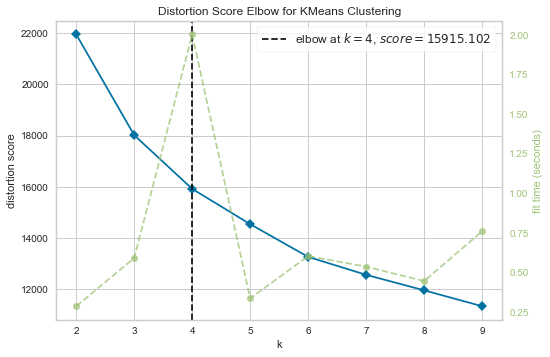

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_useless)
visualizer.show()

/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


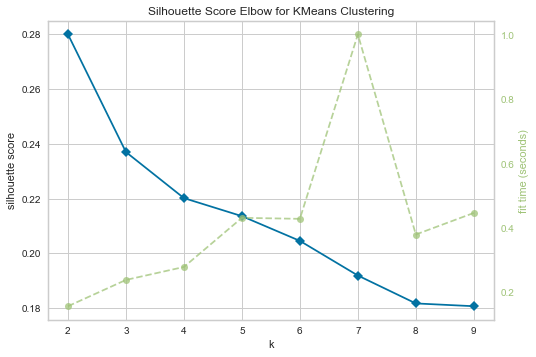

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [37]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_useless)
visualizer.show()

/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


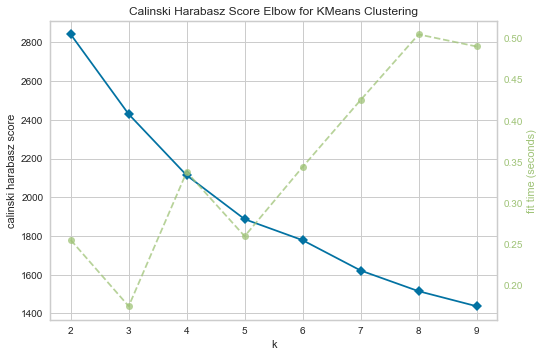

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [38]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), metric='calinski_harabasz')

visualizer.fit(X_useless)
visualizer.show()

According to KElbowVisulize, the best number of cluster is 4.

## Create the cluster

In [39]:
km=KMeans(4)
km.fit(X_useless)
km.predict(X_useless)

array([3, 3, 3, ..., 3, 1, 3], dtype=int32)

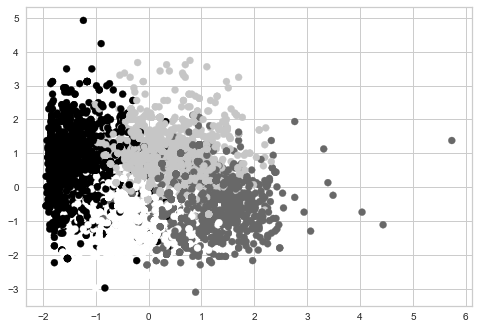

In [40]:
plt.scatter(X_useless.iloc[:,2],X_useless.iloc[:,3], c=km.predict(X_useless))

As we can the clusterisation are very dense

In [41]:
tree=DecisionTreeClassifier()
tree.fit(X_useless, km.predict(X_useless))

DecisionTreeClassifier()

In [42]:
confusion_matrix(km.predict(X_useless), tree.predict(X_useless))

array([[1703,    0,    0,    0],
       [   0, 1574,    0,    0],
       [   0,    0, 1641,    0],
       [   0,    0,    0, 1466]])

[0.23659144 0.11923058 0.29214324 0.22660367 0.12543106]


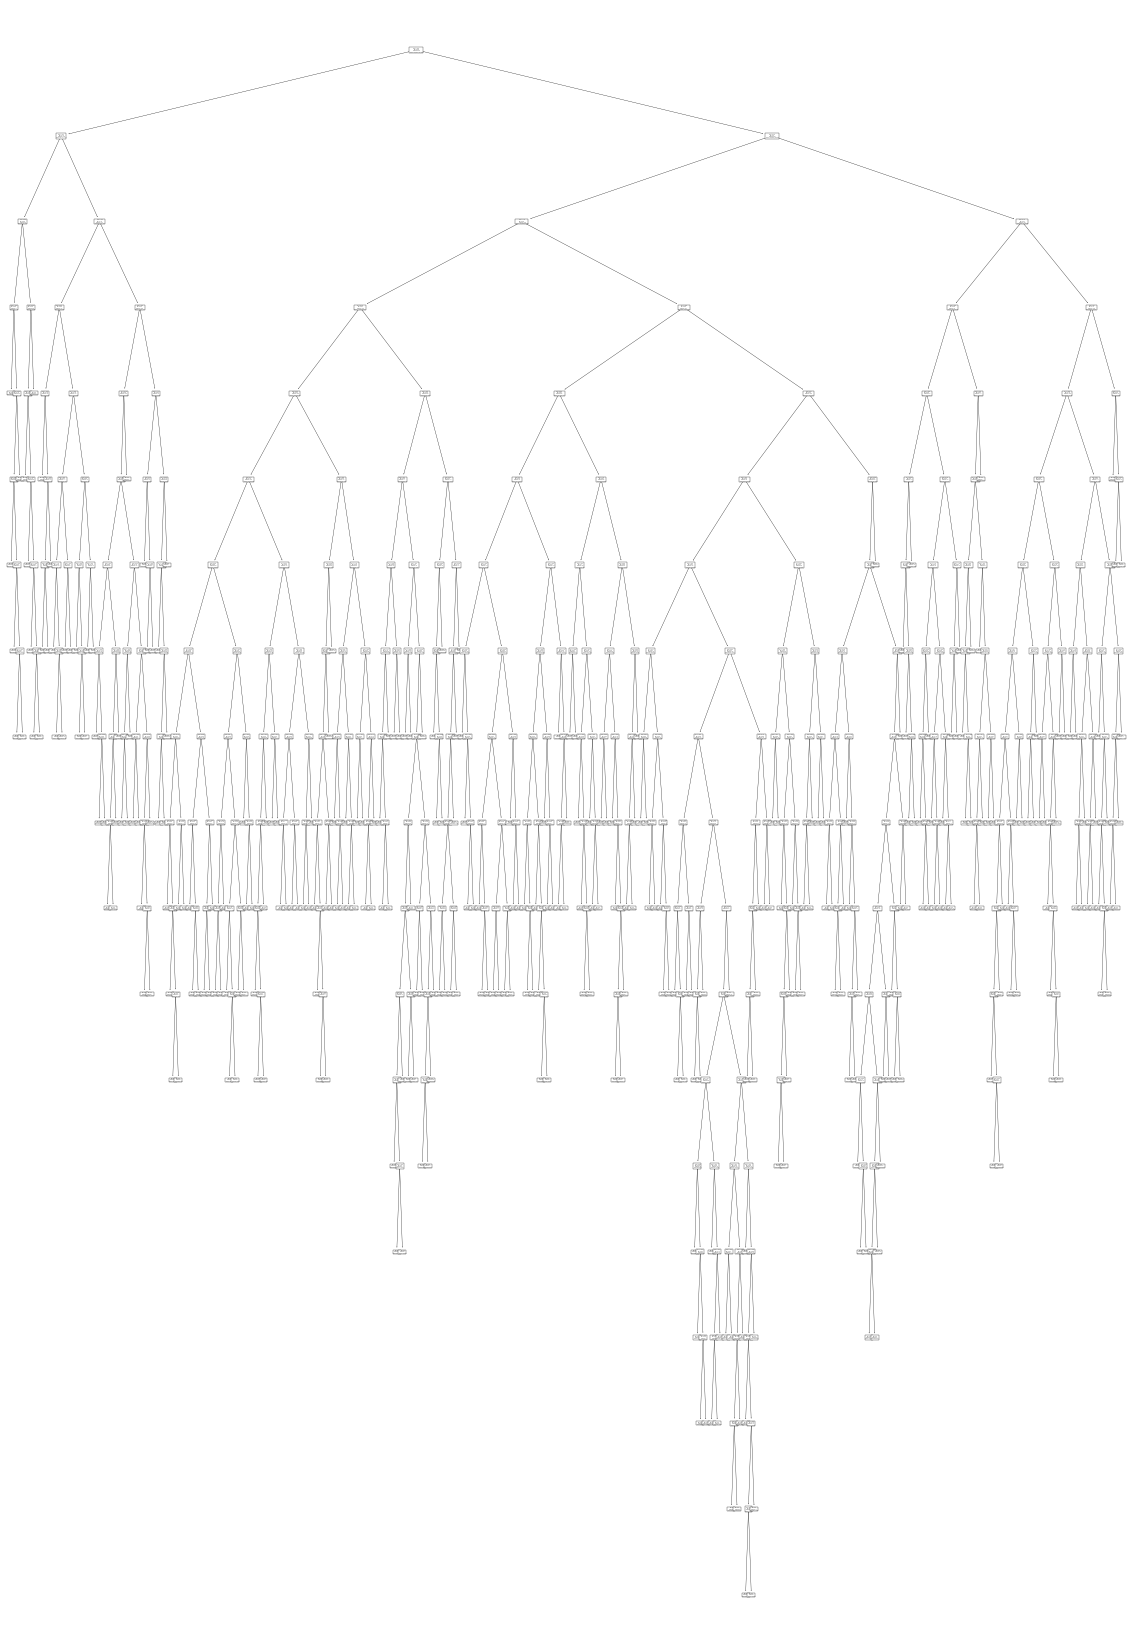

In [43]:
print(tree.feature_importances_)
plt.figure(figsize=(20,30))
plot_tree(tree)
plt.show()

As we can see, there are lots of branches. It confirm that my clusterisation is very dense.

In [44]:
print('Bouldin score is', davies_bouldin_score(X_useless, km.predict(X_useless)))
print('Silhouette score is', silhouette_score(X_useless, km.predict(X_useless)))

Bouldin score is 1.4125268050435094
Silhouette score is 0.22017208556014725


In [45]:
# Create labels
labels=km.labels_
labels

array([3, 3, 3, ..., 3, 1, 3], dtype=int32)

In [46]:
# Identify the count of each cluster
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([1703, 1574, 1641, 1466]))

Now we need to add the labels column into X as dummies

In [47]:
# Add the label column
X_im['label']=labels

In [48]:
# Get dummies for label column
X_cluster=pd.get_dummies(data=X_im, columns=['label'])

In [49]:
# Drop useless columns
X_cluster.drop(['free sulfur dioxide','total sulfur dioxide','pH','sulphates'], axis=1, inplace=True)

In [50]:
X_cluster.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.142473          2.188833    -2.192833       -0.744778   0.569958   
1       0.451036          3.282235    -2.192833       -0.597640   1.197975   
2       0.451036          2.553300    -1.917553       -0.660699   1.026697   
3       0.142473          2.188833    -2.192833       -0.744778   0.569958   
4       0.142473          1.945855    -2.192833       -0.765798   0.541412   

    density   alcohol  label_0  label_1  label_2  label_3  
0  1.034993 -0.915464        0        0        0        1  
1  0.701486 -0.580068        0        0        0        1  
2  0.768188 -0.580068        0        0        0        1  
3  1.034993 -0.915464        0        0        0        1  
4  1.034993 -0.915464        0        0        0        1

# Modelling

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_cluster, \
                                                  y_im, \
                                                  train_size=0.8, \
                                                  random_state=42, \
                                                  stratify=y_im)

## Using Pycaret

In order to use Pycaret, we will use google collab

In [52]:
# Copy X in another df in order to use it in Google Collab
df_colab=X_cluster.copy()

In [53]:
# Add y to the new df
df_colab['y']=y_im.values

In [54]:
# Extract the file
df_colab.to_csv('df_colab.csv', sep='/', index=False)

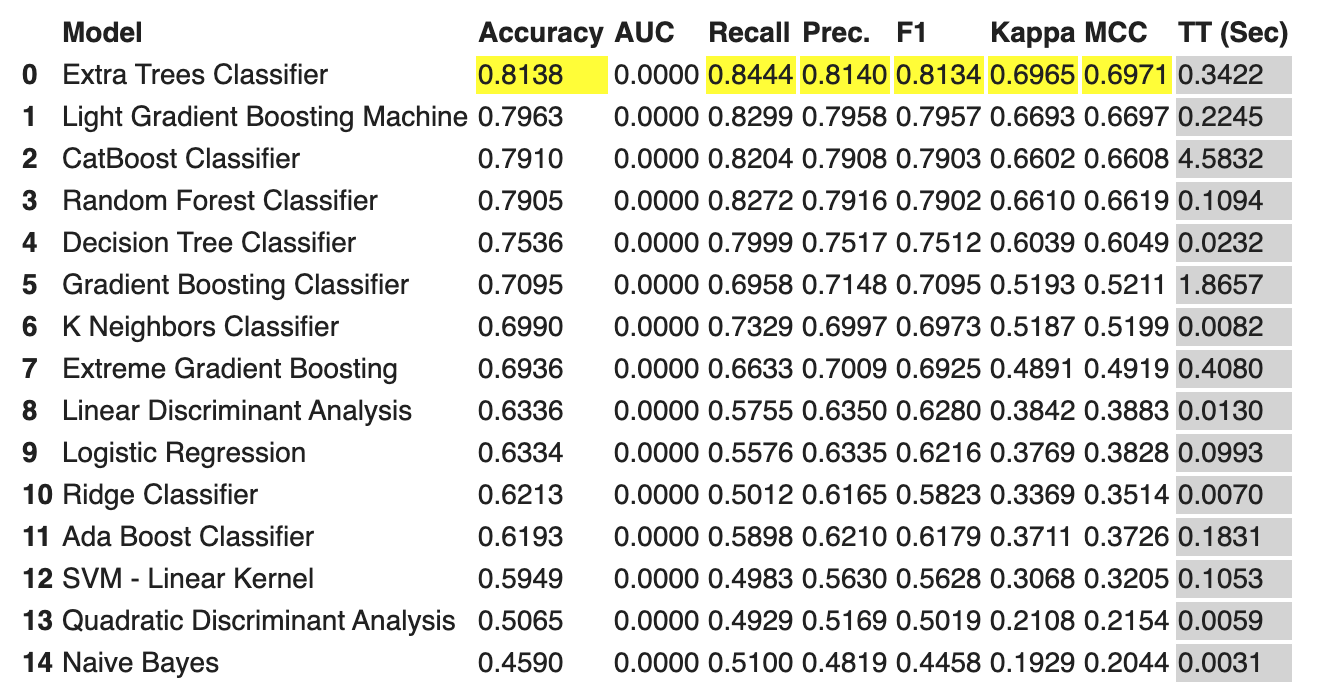

In [55]:
from IPython.display import Image
Image('/Users/Jeff/Desktop/Capture d’écran 2020-10-16 à 15.11.47.png')

As we can see the best model is Extra Trees Classifier

## Decision Tree

In [56]:
model_tree=DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
y_pred_tree=model_tree.predict(X_test)
conf_tree=confusion_matrix(y_test, y_pred_tree)
acc_tree=accuracy_score(y_test, y_pred_tree)
rec_tree=recall_score(y_test, y_pred_tree, average='macro')
pre_tree=precision_score(y_test, y_pred_tree, average='macro')
f1_tree=f1_score(y_test, y_pred_tree, average='macro')
display(conf_tree)
print('Accuracy', acc_tree)
print('Recall', rec_tree)
print('Precision', pre_tree)
print('F1', f1_tree)

array([[335, 140,   2],
       [126, 454,  20],
       [  0,   0, 200]])

Accuracy 0.7744714173844949
Recall 0.8196575821104123
Precision 0.7972972643977706
F1 0.8075406748630688


## Random forest

In [57]:
model_rf=RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf=model_rf.predict(X_test)
conf_rf=confusion_matrix(y_test, y_pred_rf)
acc_rf=accuracy_score(y_test, y_pred_rf)
rec_rf=recall_score(y_test, y_pred_rf, average='macro')
pre_rf=precision_score(y_test, y_pred_rf, average='macro')
f1_rf=f1_score(y_test, y_pred_rf, average='macro')
display(conf_rf)
print('Accuracy', acc_rf)
print('Recall', rec_rf)
print('Precision', pre_rf)
print('F1', f1_rf)

array([[364, 113,   0],
       [109, 485,   6],
       [  0,   0, 200]])

Accuracy 0.8214565387627252
Recall 0.8571453529000698
Precision 0.850488867025135
F1 0.8537400896749964


## Extra Trees Classifier (with clustering)

### Using macro average

In [58]:
model_xt=ExtraTreesClassifier()
model_xt.fit(X_train, y_train)
y_pred_xt=model_xt.predict(X_test)
y_pred_xt___=model_xt.predict_proba(X_test)

conf_xt=confusion_matrix(y_test, y_pred_xt)
acc_xt=accuracy_score(y_test, y_pred_xt)
rec_xt=recall_score(y_test, y_pred_xt, average='macro')
pre_xt=precision_score(y_test, y_pred_xt, average='macro')
f1_xt=f1_score(y_test, y_pred_xt, average='macro')
roc_auc_score_xt=roc_auc_score(y_test, y_pred_xt___, multi_class='ovo')
display(conf_xt)
print('Accuracy', acc_xt)
print('Recall', rec_xt)
print('Precision', pre_xt)
print('F1', f1_xt)
print('AUC', roc_auc_score_xt)

array([[363, 114,   0],
       [107, 489,   4],
       [  0,   0, 200]])

Accuracy 0.8238057948316366
Recall 0.8586687631027253
Precision 0.8545592853421669
F1 0.8565660195804674
AUC 0.9607159911483811


### Using micro average

In [59]:
model_xt=ExtraTreesClassifier()
model_xt.fit(X_train, y_train)
y_pred_xt=model_xt.predict(X_test)
y_pred_xt___=model_xt.predict_proba(X_test)

conf_xt=confusion_matrix(y_test, y_pred_xt)
acc_xt=accuracy_score(y_test, y_pred_xt)
rec_xt=recall_score(y_test, y_pred_xt, average='micro')
pre_xt=precision_score(y_test, y_pred_xt, average='micro')
f1_xt=f1_score(y_test, y_pred_xt, average='micro')
roc_auc_score_xt=roc_auc_score(y_test, y_pred_xt___, multi_class='ovo')
display(conf_xt)
print('Accuracy', acc_xt)
print('Recall', rec_xt)
print('Precision', pre_xt)
print('F1', f1_xt)
print('AUC', roc_auc_score_xt)

array([[355, 122,   0],
       [114, 483,   3],
       [  0,   0, 200]])

Accuracy 0.8128425998433829
Recall 0.8128425998433829
Precision 0.8128425998433829
F1 0.8128425998433829
AUC 0.9601109364081063


## Extra Tree Classifier (without clustering)

In [60]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_im, \
                                                  y_im, \
                                                  train_size=0.8, \
                                                  random_state=42, \
                                                  stratify=y_im)

### Using macro average

In [61]:
model_xt1=ExtraTreesClassifier()
model_xt1.fit(X_train1, y_train1)
y_pred_xt1=model_xt1.predict(X_test1)
y_pred_xt1___=model_xt1.predict_proba(X_test1)

conf_xt1=confusion_matrix(y_test1, y_pred_xt1)
acc_xt1=accuracy_score(y_test1, y_pred_xt1)
rec_xt1=recall_score(y_test1, y_pred_xt1, average='macro')
pre_xt1=precision_score(y_test1, y_pred_xt1, average='macro')
f1_xt1=f1_score(y_test1, y_pred_xt1, average='macro')
roc_auc_score_xt1=roc_auc_score(y_test1, y_pred_xt1___, multi_class='ovo')
display(conf_xt1)
print('Accuracy', acc_xt1)
print('Recall', rec_xt1)
print('Precision', pre_xt1)
print('F1', f1_xt1)
print('AUC', roc_auc_score_xt1)

array([[379,  98,   0],
       [ 99, 500,   1],
       [  0,   0, 200]])

Accuracy 0.8449490994518403
Recall 0.8759608665269042
Precision 0.8746774354161286
F1 0.8753160176007929
AUC 0.9662945492662475


### Using micro average

In [62]:
model_xt1=ExtraTreesClassifier()
model_xt1.fit(X_train1, y_train1)
y_pred_xt1=model_xt1.predict(X_test1)
y_pred_xt1___=model_xt1.predict_proba(X_test1)

conf_xt1=confusion_matrix(y_test1, y_pred_xt1)
acc_xt1=accuracy_score(y_test1, y_pred_xt1)
rec_xt1=recall_score(y_test1, y_pred_xt1, average='micro')
pre_xt1=precision_score(y_test1, y_pred_xt1, average='micro')
f1_xt1=f1_score(y_test1, y_pred_xt1, average='micro')
roc_auc_score_xt1=roc_auc_score(y_test1, y_pred_xt1___, multi_class='ovo')
display(conf_xt1)
print('Accuracy', acc_xt1)
print('Recall', rec_xt1)
print('Precision', pre_xt1)
print('F1', f1_xt1)
print('AUC', roc_auc_score_xt1)

array([[375, 102,   0],
       [ 98, 501,   1],
       [  0,   0, 200]])

Accuracy 0.8425998433829287
Recall 0.8425998433829287
Precision 0.8425998433829287
F1 0.8425998433829288
AUC 0.9662406825064057
